In [1]:
# 필요한 라이브러리 정리하기

import os.path
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import perf_counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import json

def read_labels(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # 카테고리 id와 이름을 매핑한 딕셔너리를 생성
    categories = {category['id']: category['name'] for category in data['categories']}
    images = {image['id']: image['file_name'] for image in data['images']}

    # 이미지 파일명과 이미지 라벨을 매핑한 딕셔너리를 생성
    labels = {images[annotation['image_id']]: categories[annotation['category_id']] for annotation in data['annotations']}

    return labels
json_directory = 'noseprints/data/json' 
json_files = [os.path.join(json_directory, f) for f in os.listdir(json_directory) if f.endswith('.json')]

label_map = {}
for f in json_files:
    label_map.update(read_labels(f))

print(label_map)  # 라벨링 맵 확인

{'a001_1.jpg': 'a001', 'a001_2.jpg': 'a001', 'a001_3.jpg': 'a001', 'a001_4.jpg': 'a001', 'a001_5.jpg': 'a001', 'a001_6.jpg': 'a001', 'a001_7.jpg': 'a001', 'a001_8.jpg': 'a001', 'a001_9.jpg': 'a001', 'a001_10.jpg': 'a001', 'a001_11.jpg': 'a001', 'a002_1.jpg': 'a002', 'a002_2.jpg': 'a002', 'a002_3.jpg': 'a002', 'a002_4.jpg': 'a002', 'a002_5.jpg': 'a002', 'a002_6.jpg': 'a002', 'a003_1.jpg': 'a003', 'a003_2.jpg': 'a003', 'a003_3.jpg': 'a003', 'a003_4.jpg': 'a003', 'a003_5.jpg': 'a003', 'a003_6.jpg': 'a003', 'a003_7.jpg': 'a003', 'a003_8.jpg': 'a003', 'a003_9.jpg': 'a003', 'a004_1.jpg': 'a004', 'a004_2.jpg': 'a004', 'a004_3.jpg': 'a004', 'a004_4.jpg': 'a004', 'a004_5.jpg': 'a004', 'a005_1.jpg': 'a005', 'a005_2.jpg': 'a005', 'a006_1.jpg': 'a006', 'a006_2.jpg': 'a006', 'a006_3.jpg': 'a006', 'a006_4.jpg': 'a006', 'a006_5.jpg': 'a006', 'a006_6.jpg': 'a006', 'a006_7.jpg': 'a006', 'a007_1.jpg': 'a007', 'a007_2.jpg': 'a007', 'a007_3.jpg': 'a007', 'a008_1.jpg': 'a008', 'a008_10.jpg': 'a008', 'a008_

In [4]:
df = pd.DataFrame(list(label_map.items()), columns=['Filepath', 'Label'])

# 이미지가 저장되어 있는 기본 디렉토리
base_dir = 'noseprints/data/images'

# Filepath 컬럼의 각 값을 절대 경로로 바꿉니다.
df['Filepath'] = df['Filepath'].apply(lambda x: os.path.join(base_dir, x).replace('\\', '/'))
df.head()

,Filepath,Label
0,noseprints/data/images/a001_1.jpg,a001
1,noseprints/data/images/a001_2.jpg,a001
2,noseprints/data/images/a001_3.jpg,a001
3,noseprints/data/images/a001_4.jpg,a001
4,noseprints/data/images/a001_5.jpg,a001


In [5]:
# 이미지 개수 및 클래스 개수(종류 수) 확인하기

labels = df['Label'].values.tolist()

label_list=[]
for i in labels:
    if i not in label_list:
        label_list.append(i)

print('The number of pictures:', df.shape[0])
print('The number of labels:', len(label_list))
print('Labels:', label_list)

The number of pictures: 376
The number of labels: 90
Labels: ['a001', 'a002', 'a003', 'a004', 'a005', 'a006', 'a007', 'a008', 'a009', 'a010', 'a011', 'a012', 'a013', 'a014', 'a015', 'a016', 'a017', 'a018', 'a019', 'a020', 'a022', 'a024', 'a026', 'a027', 'a028', 'b004', 'b005', 'b006', 'b009', 'b012', 'b016', 'b017', 'b021', 'b022', 'b027', 'b035', 'b036', 'b039', 'b041', 'b042', 'b046', 'b049', 'b052', 'b053', 'b057', 'b062', 'b063', 'b111', 'b112', 'b114', 'b117', 'b119', 'b120', 'b130', 'b133', 'b135', 'b136', 'b137', 'b142', 'b143', 'b144', 'b145', 'b146', 'b147', 'b149', 'b156', 'b158', 'b159', 'b162', 'b163', 'b164', 'b171', 'b172', 'b174', 'b178', 'b179', 'b198', 'b212', 'b213', 'b214', 'b229', 'b231', 'b232', 'b235', 'b237', 'b239', 'b267', 'b278', 'b284', 'b286']


In [6]:
# Label 컬럼 중 같은 변수가 3개 이하인 행 제거
df = df.groupby('Label').filter(lambda x: len(x) > 3)
df.tail()

,Filepath,Label
350,noseprints/data/images/b231_9.jpg,b231
351,noseprints/data/images/b232_1.jpg,b232
352,noseprints/data/images/b232_2.jpg,b232
353,noseprints/data/images/b232_3.jpg,b232
354,noseprints/data/images/b232_4.jpg,b232


In [7]:
df = df.reset_index(drop=True)

In [8]:
# train, test set으로 split(3대 1 비율)
from sklearn.model_selection import StratifiedShuffleSplit # 모든 클래스의 비율을 동일하게 유지하면서 데이터를 나눠줌

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=11)

for train_index, test_index in sss.split(df['Filepath'], df['Label']):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]

In [9]:
# train, test 세트의 class 수 확인
print('The number of train set:', train_df.shape[0])
print('The number of test set:', test_df.shape[0])

The number of train set: 193
The number of test set: 65


In [10]:
# train_df를 9대 1로 split(train과 valid로)

train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)
train_df.shape, valid_df.shape

((173, 2), (20, 2))

In [11]:
# ImageDataGenerator 적용 과정(이미지 증강 과정)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40, # 회전제한 각도 40도
                                   zoom_range=0.2, # 확대 축소 20%
                                   width_shift_range=0.2, # 좌우이동 20%
                                   height_shift_range=0.2, # 상하이동 20%
                                   shear_range=0.2, # 반시계방햐의 각도
                                   horizontal_flip=True, # 좌우 반전 True
                                   fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(128, 128),
                                                    batch_size=75,
                                                    class_mode='categorical'
                                                    )

validation_generator = valid_datagen.flow_from_dataframe(valid_df,
                                                     x_col='Filepath',
                                                     y_col='Label',
                                                     target_size=(128, 128),
                                                     batch_size=75,
                                                     class_mode='categorical'
                                                     )

Found 173 validated image filenames belonging to 50 classes.
Found 20 validated image filenames belonging to 14 classes.


In [43]:
# session clear
tf.keras.backend.clear_session()

# 이미지 손상 오류 해결
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [44]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

# 1. Learning rate schedule 함수 정의
initial_learning_rate = 1e-2
first_decay_steps = 30

def lr_decayed_fn(epoch, lr):
    return tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate,
        first_decay_steps)(epoch)

# 2. LearningRateScheduler 콜백 생성
lr_callback = LearningRateScheduler(lr_decayed_fn)

# 3. Optimizer 설정
optimizer = optimizers.Adam(learning_rate = initial_learning_rate)

# 4. BatchNormalization 추가
RN152_2 = tf.keras.applications.resnet_v2.ResNet152V2(weights="imagenet",
                                          include_top=False, 
                                          input_shape=(128, 128, 3))

RN152_2.trainable = False 

# 5. EarlyStopping 콜백 생성
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# 6. 모델 제작
model = models.Sequential(name="ResNet152v2_RT")
model.add(RN152_2)

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(50, activation = 'softmax'))

# 7. Optimizer에 적용
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

model.summary()

Model: "ResNet152v2_RT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 50)             

In [46]:
# 8. 학습 적용
history = model.fit(train_generator,
                    steps_per_epoch = train_df.shape[0]//75,
                    epochs = 1000,
                    validation_data = validation_generator,
                    validation_steps = valid_df.shape[0]//75,
                    callbacks=[lr_callback, early_stopping])

Epoch 1/1000


KeyboardInterrupt: 

In [40]:
# Test 데이터셋으로 성능 확인하기

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(128, 128),
                                                  batch_size=75)
                                                  
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Found 65 validated image filenames belonging to 50 classes.
1/1 [==============================] - 10s 10s/step - loss: 5.3530 - accuracy: 0.6308
Loss = 5.35301
Accuracy = 0.63077


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

# 예측값 생성
test_generator.reset()
predictions = model.predict(test_generator, steps=math.ceil(test_generator.n/test_generator.batch_size), verbose=1) # 예측값 올림
predicted_classes = np.argmax(predictions, axis=1)

# 실제값 가져오기
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

# Confusion Matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

1/1 [==============================] - 9s 9s/step
              precision    recall  f1-score   support

        a001       0.00      0.00      0.00         3
        a002       0.00      0.00      0.00         2
        a003       0.50      0.50      0.50         2
        a004       0.00      0.00      0.00         1
        a006       0.00      0.00      0.00         2
        a008       0.00      0.00      0.00         3
        a011       0.00      0.00      0.00         1
        a012       0.00      0.00      0.00         1
        a013       0.00      0.00      0.00         2
        a015       0.00      0.00      0.00         1
        a016       0.00      0.00      0.00         2
        a019       0.00      0.00      0.00         2
        a020       0.00      0.00      0.00         2
        a022       0.00      0.00      0.00         2
        a024       0.00      0.00      0.00         2
        a026       1.00      1.00      1.00         1
        a027       0.00      0.

c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


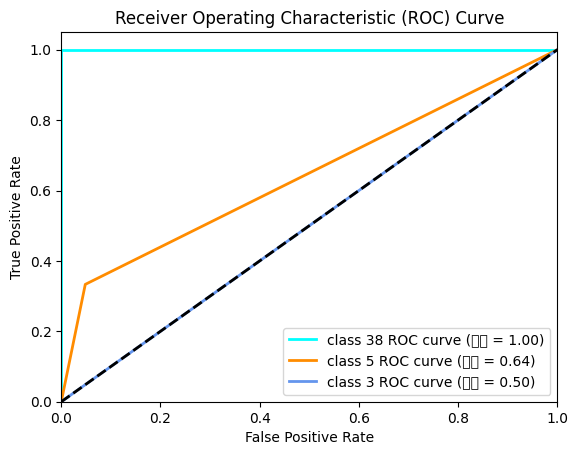

In [ ]:
# 상위 3개 결과에 대한 ROC 커브 시각화

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

# 레이블 이진화
lb = LabelBinarizer()
lb.fit(true_classes)
bin_true_classes = lb.transform(true_classes)
bin_predicted_classes = lb.transform(predicted_classes)

n_classes = bin_true_classes.shape[1]

# 각 클래스에 대한 ROC 커브와 ROC 영역 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_true_classes[:, i], bin_predicted_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC AUC 점수로 클래스 정렬
sorted_classes = sorted(roc_auc, key=roc_auc.get, reverse=True)

# 상위 3개 클래스의 ROC 커브 플롯
plt.figure()

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(sorted_classes[:3], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='class {0} ROC curve (영역 = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 3s 3s/step


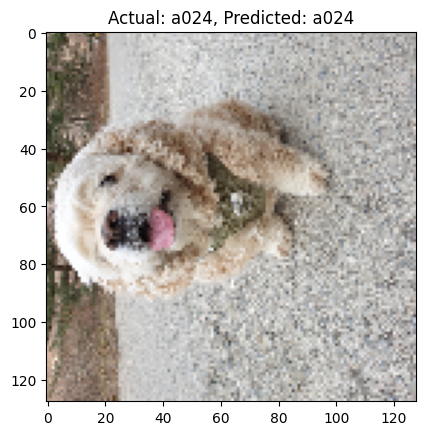

1/1 [==============================] - 0s 133ms/step


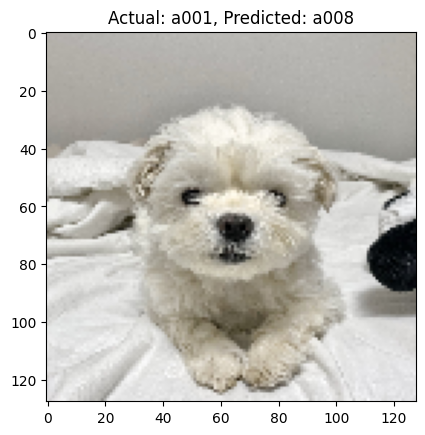

1/1 [==============================] - 0s 129ms/step


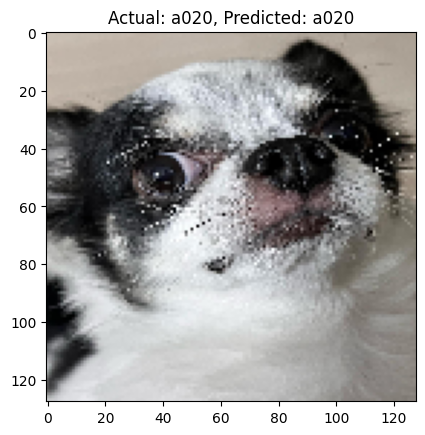

1/1 [==============================] - 0s 225ms/step


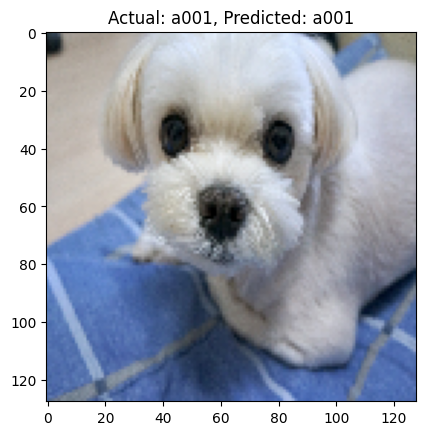

1/1 [==============================] - 0s 130ms/step


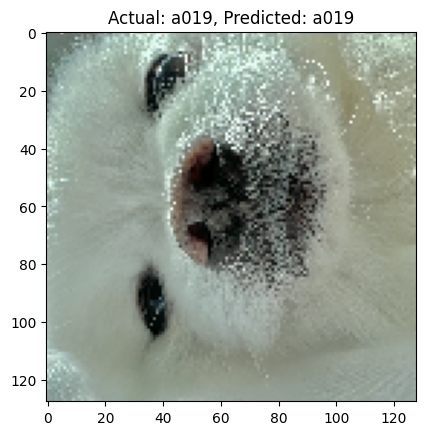

1/1 [==============================] - 0s 179ms/step


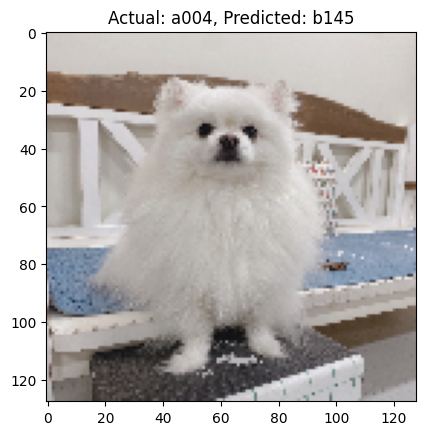

1/1 [==============================] - 0s 127ms/step


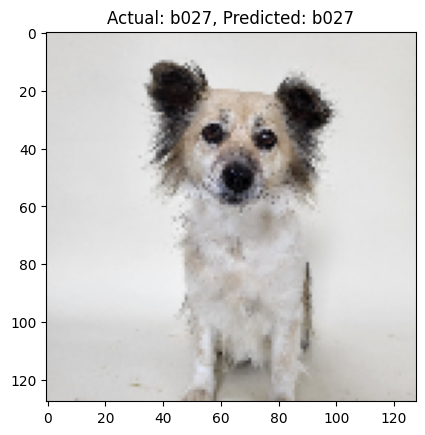

1/1 [==============================] - 0s 123ms/step


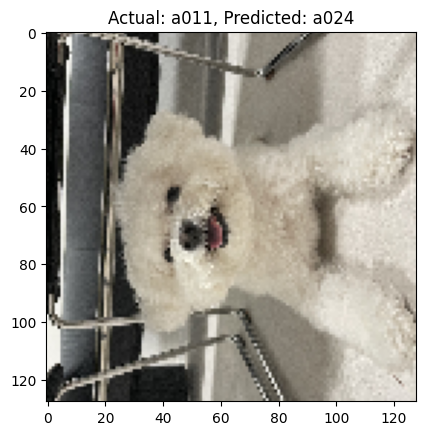

1/1 [==============================] - 0s 474ms/step


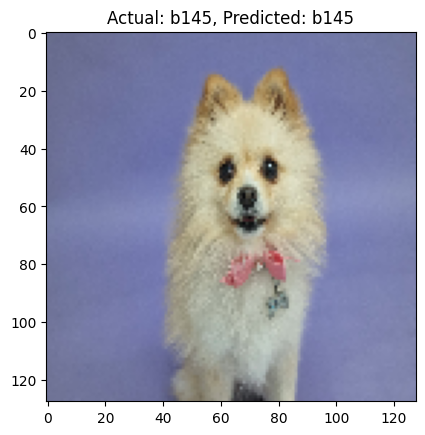

1/1 [==============================] - 0s 133ms/step


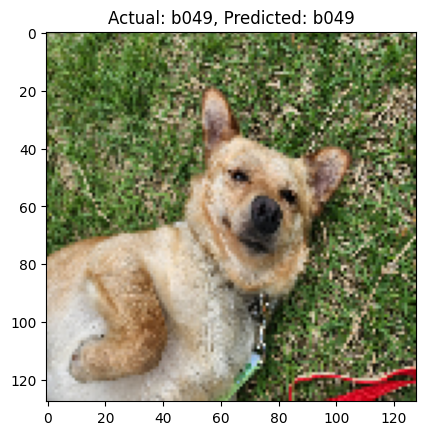

Accuracy = 0.70


In [ ]:
# 예측 결과 시각화
correct_predictions = 0
total_predictions = 0
test_generator.reset()
for i in range(10):  # 이 값을 조절해서 원하는 이미지 갯수 선택 가능
    x, y = test_generator.next()
    image = x[0]
    actual_label = class_labels[np.argmax(y[0])]
    predicted_label = class_labels[np.argmax(model.predict(np.expand_dims(image, axis=0)))]
    
    if actual_label == predicted_label:
        correct_predictions += 1
    total_predictions += 1

    plt.imshow(image)
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.show()

accuracy = correct_predictions / total_predictions
print(f"Accuracy = {accuracy:.2f}")

In [81]:
model.save('ResNet_test6.h5')